#GIT LINKING

In [2]:


# !pip install NumPy
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import re

# Problem 1



#Data Loading (MovieLens ml-latest-small)


In [4]:
# zip_file_name = 'ml-latest-small.zip'
# with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
#     zip_ref.extractall('.')

# files_after_unzip = os.listdir('.')
# print(f"Files now available: {files_after_unzip}")

try:
    path = 'ml-latest-small/'

    movies = pd.read_csv(path + 'movies.csv')
    ratings = pd.read_csv(path + 'ratings.csv')
    tags = pd.read_csv(path + 'tags.csv')

    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

    df = pd.merge(ratings, movies, on='movieId')

    print("Success! table created.")
    print(df.head())

except Exception as e:
    print(f" error: {e}")

Success! table created.
   userId  movieId  rating           timestamp                        title  \
0       1        1     4.0 2000-07-30 18:45:03             Toy Story (1995)   
1       1        3     4.0 2000-07-30 18:20:47      Grumpier Old Men (1995)   
2       1        6     4.0 2000-07-30 18:37:04                  Heat (1995)   
3       1       47     5.0 2000-07-30 19:03:35  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0 2000-07-30 18:48:51   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


#DATA CLEANING


In [5]:

ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId'], keep='last')

def extract_year(title):
    year = re.search(r'\((\d{4})\)', title)
    if year:
        return int(year.group(1))
    return np.nan

movies['year'] = movies['title'].apply(extract_year)
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.strip()
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|'))
tags['tag'] = tags['tag'].str.lower().str.strip()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
movie_counts = ratings['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 5].index
ratings_cleaned = ratings[ratings['movieId'].isin(popular_movies)]
user_counts = ratings_cleaned['userId'].value_counts()
active_users = user_counts[user_counts >= 20].index
ratings_cleaned = ratings_cleaned[ratings_cleaned['userId'].isin(active_users)]

# FINAL MERGE
df_clean = pd.merge(ratings_cleaned, movies, on='movieId')

print(" Cleaning Complete!")
print(f"Total ratings after filtering noise: {len(df_clean)}")
print(df_clean[['userId', 'title', 'year', 'genres_list']].head())

 Cleaning Complete!
Total ratings after filtering noise: 90137
   userId                                         title    year  \
0     429                          Beauty and the Beast  1991.0   
1     429                                       Aladdin  1992.0   
2     429                            Dances with Wolves  1990.0   
3     429                                        Batman  1989.0   
4     429  City Slickers II: The Legend of Curly's Gold  1994.0   

                                         genres_list  
0  [Animation, Children, Fantasy, Musical, Romanc...  
1  [Adventure, Animation, Children, Comedy, Musical]  
2                        [Adventure, Drama, Western]  
3                          [Action, Crime, Thriller]  
4                       [Adventure, Comedy, Western]  


# LEAVE-LAST-N SPLIT

In [6]:
#to check that there is no data leakage, proper recommender validator, etc.
def leave_last_n_strict(
    df,
    user_col="userId",
    time_col="timestamp",
    n=1,
    min_interactions=5
):
    df = df.sort_values([user_col, time_col])

    train_rows = []
    test_rows = []

    for user, user_df in df.groupby(user_col):
        if len(user_df) < min_interactions:
            continue

        test_part = user_df.tail(n)
        train_part = user_df.iloc[:-n]

        train_rows.append(train_part)
        test_rows.append(test_part)

    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)

    return train_df, test_df


In [7]:
train_df, test_df = leave_last_n_strict(df_clean)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print(train_df.head())
print(test_df.head())


Train size: 89535
Test size: 602
       userId  movieId  rating           timestamp  \
14361       1      804     4.0 2000-07-30 18:08:19   
14362       1     1210     5.0 2000-07-30 18:08:19   
14363       1     2628     4.0 2000-07-30 18:08:43   
14364       1     2826     4.0 2000-07-30 18:08:43   
14365       1     2018     5.0 2000-07-30 18:08:43   

                                            title                    genres  \
14361                               She's the One            Comedy|Romance   
14362  Star Wars: Episode VI - Return of the Jedi   Action|Adventure|Sci-Fi   
14363   Star Wars: Episode I - The Phantom Menace   Action|Adventure|Sci-Fi   
14364                           13th Warrior, The  Action|Adventure|Fantasy   
14365                                       Bambi  Animation|Children|Drama   

         year                   genres_list  
14361  1996.0             [Comedy, Romance]  
14362  1983.0   [Action, Adventure, Sci-Fi]  
14363  1999.0   [Action, Adve

# USER-ITEM INTERACTION MATRIX (Training Data Only)

In [8]:
user_item_train = train_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [9]:
print(user_item_train.shape)


(602, 3650)


#ITEM–ITEM SIMILARITY COMPUTATION (Cosine Similarity)

In [10]:
import numpy as np
from numpy.linalg import norm

item_vectors = user_item_train.T.values

similarity = item_vectors @ item_vectors.T
similarity = similarity / (
    norm(item_vectors, axis=1)[:, None] *
    norm(item_vectors, axis=1)[None, :]
)


#Content-Based Feature Engineering

In [12]:
# Global Movie ID ↔ Index Mapping
movie_id_to_idx = {
    movie_id: idx
    for idx, movie_id in enumerate(movies['movieId'])
}

idx_to_movie_id = {
    idx: movie_id
    for movie_id, idx in movie_id_to_idx.items()
}


In [13]:
# Align the full genre matrix with your specific training movies
train_movie_indices = [movie_id_to_idx[m_id] for m_id in user_item_train.columns]

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Prepare genre strings (joining with spaces for TF-IDF)
movies['genres_str'] = movies['genres'].str.replace('|', ' ')

# 2. Compute TF-IDF Matrix for genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres_str'])

# 3. Compute Content Similarity matrix
genre_sim = cosine_similarity(tfidf_matrix)

# Mapping for indexing
movie_id_to_idx = {id: i for i, id in enumerate(movies['movieId'])}

#Hybrid Recommendation Model (CF + Content)

In [15]:
def recommend_top_k(user_id, K=10, alpha=0.7):
    if user_id not in user_item_train.index:
        return []

    user_idx = user_item_train.index.get_loc(user_id)
    user_ratings = user_item_train.iloc[user_idx].values

    # 1. FAST Collaborative Filtering (Matrix Math)
    cf_scores = user_ratings @ similarity

    # 2. FAST Vectorized Content Score
    liked_movie_ids = train_df[(train_df['userId'] == user_id) & (train_df['rating'] >= 4)]['movieId'].tolist()

    if liked_movie_ids:
        liked_idxs = [movie_id_to_idx[m] for m in liked_movie_ids if m in movie_id_to_idx]
        # Optimized: Grab all similarities at once using NumPy slicing
        content_scores = genre_sim[liked_idxs, :][:, train_movie_indices].sum(axis=0)
    else:
        content_scores = np.zeros(len(user_item_train.columns))

    # 3. Normalization & Blending (Ensuring variable 'alpha' is correct)
    cf_norm = (cf_scores - cf_scores.min()) / (cf_scores.max() - cf_scores.min() + 1e-9)
    ct_norm = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min() + 1e-9)

    final_scores = (alpha * cf_norm) + ((1 - alpha) * ct_norm)

    # Filter out already watched and rank
    final_scores[user_ratings > 0] = -1
    top_k_indices = np.argsort(final_scores)[-K:][::-1]

    return user_item_train.columns[top_k_indices]

In [16]:
sample_user = train_df['userId'].iloc[0]
recommended_movies = recommend_top_k(sample_user, K=10)

recommended_movies


movies[['movieId', 'title', 'genres']].set_index('movieId').loc[recommended_movies]



,title,genres
movieId,,
1527,"Fifth Element, The",Action|Adventure|Comedy|Sci-Fi
2683,Austin Powers: The Spy Who Shagged Me,Action|Adventure|Comedy
1036,Die Hard,Action|Crime|Thriller
1200,Aliens,Action|Adventure|Horror|Sci-Fi
1610,"Hunt for Red October, The",Action|Adventure|Thriller
5349,Spider-Man,Action|Adventure|Sci-Fi|Thriller
1391,Mars Attacks!,Action|Comedy|Sci-Fi
1129,Escape from New York,Action|Adventure|Sci-Fi|Thriller
2918,Ferris Bueller's Day Off,Comedy


#EXPLAINABILITY LAYER

In [17]:
#we are assuming if user has given more than 4 star then he likes it...
def get_liked_movies(user_id, min_rating=4):
    liked = train_df[
        (train_df['userId'] == user_id) &
        (train_df['rating'] >= min_rating)
    ]['movieId'].unique()
    return liked


In [18]:
def get_genres(movie_id):
    genre_str = movies.loc[movies['movieId'] == movie_id, 'genres']
    if genre_str.empty:
        return set()
    return set(genre_str.values[0].split('|'))


In [19]:
# Generate Explanation for ONE Recommendation
def generate_explanation(user_id, recommended_movie_id):
    liked_movies = get_liked_movies(user_id)

    rec_genres = get_genres(recommended_movie_id)

    best_match = None
    best_overlap = set()

    for lm in liked_movies:
        lm_genres = get_genres(lm)
        overlap = rec_genres & lm_genres

        if len(overlap) > len(best_overlap):
            best_overlap = overlap
            best_match = lm

    if best_match is None or not best_overlap:
        return "Recommended based on overall similarity to your past preferences."

    liked_title = movies.loc[movies['movieId'] == best_match, 'title'].values[0]
    shared_genres = ", ".join(best_overlap)

    return f"Recommended because you liked '{liked_title}', which shares genres ({shared_genres})."


In [20]:
#testing
sample_user = train_df['userId'].iloc[0]
recommended_movies = recommend_top_k(sample_user, K=5)

for mid in recommended_movies:
    title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
    genres = movies.loc[movies['movieId'] == mid, 'genres'].values[0]
    explanation = generate_explanation(sample_user, mid)

    print(f"{title} — {genres}")
    print(f"  👉 {explanation}\n")


Fifth Element, The — Action|Adventure|Comedy|Sci-Fi
  👉 Recommended because you liked 'Star Wars: Episode VI - Return of the Jedi', which shares genres (Action, Sci-Fi, Adventure).

Austin Powers: The Spy Who Shagged Me — Action|Adventure|Comedy
  👉 Recommended because you liked 'Austin Powers: International Man of Mystery', which shares genres (Action, Comedy, Adventure).

Die Hard — Action|Crime|Thriller
  👉 Recommended because you liked 'Shaft', which shares genres (Action, Thriller, Crime).

Aliens — Action|Adventure|Horror|Sci-Fi
  👉 Recommended because you liked 'Star Wars: Episode VI - Return of the Jedi', which shares genres (Action, Sci-Fi, Adventure).

Hunt for Red October, The — Action|Adventure|Thriller
  👉 Recommended because you liked 'Dr. No', which shares genres (Action, Thriller, Adventure).



In [21]:
test_user_items = test_df.groupby('userId')['movieId'].apply(set)


#Diversity and Coverage

In [22]:
def evaluate_diversity(K=10):
    all_recs = []
    for user_id in test_user_items.index:
        all_recs.extend(recommend_top_k(user_id, K=K))

    unique_recs = set(all_recs)
    total_movies = len(movies['movieId'].unique())
    coverage = len(unique_recs) / total_movies

    print(f"--- Diversity & Coverage (K={K}) ---")
    print(f"Catalog Coverage: {coverage:.2%}")
    print(f"Unique Items Recommended: {len(unique_recs)}")

evaluate_diversity(K=10)

--- Diversity & Coverage (K=10) ---
Catalog Coverage: 6.20%
Unique Items Recommended: 604


In [23]:
def recall_at_k(user_id, K=5):
    if user_id not in test_user_items:
        return None

    recommended = set(recommend_top_k(user_id, K))
    relevant = test_user_items[user_id]

    return len(recommended & relevant) / len(relevant)

def precision_at_k(user_id, K=5):
    if user_id not in test_user_items:
        return None

    # Use recommend_top_k (ensure this name matches your model function)
    recommended = set(recommend_top_k(user_id, K))
    relevant = test_user_items[user_id]

    # Precision = (Recommended & Relevant) / K
    return len(recommended & relevant) / K

In [24]:
def evaluate_model(K=5):
    precisions = []
    recalls = []

    for user_id in test_user_items.index:
        p = precision_at_k(user_id, K)
        r = recall_at_k(user_id, K)

        if p is not None and r is not None:
            precisions.append(p)
            recalls.append(r)

    return {
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls)
    }


In [25]:
for K in [5, 10, 20]:
    print(f"K={K}", evaluate_model(K))



K=5 {'Precision@K': np.float64(0.006312292358803987), 'Recall@K': np.float64(0.03156146179401993)}
K=10 {'Precision@K': np.float64(0.0049833887043189366), 'Recall@K': np.float64(0.04983388704318937)}
K=20 {'Precision@K': np.float64(0.004651162790697675), 'Recall@K': np.float64(0.09302325581395349)}


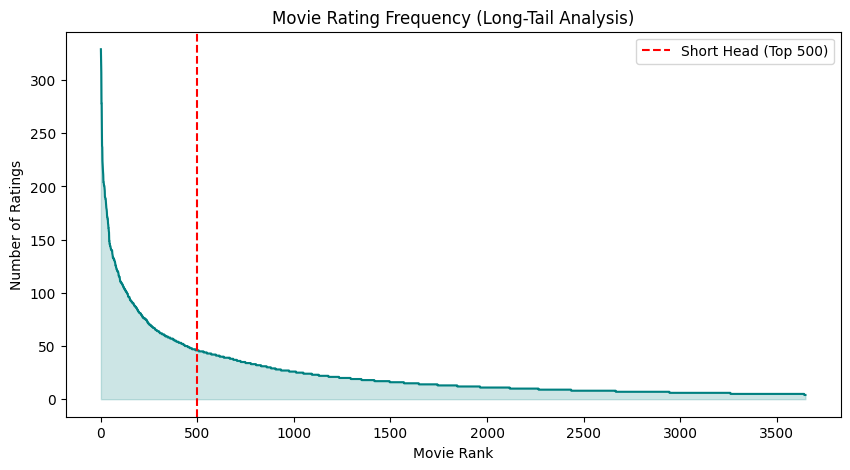

In [26]:
import matplotlib.pyplot as plt

movie_rating_counts = df_clean['movieId'].value_counts().values
plt.figure(figsize=(10, 5))
plt.plot(movie_rating_counts, color='teal')
plt.title('Movie Rating Frequency (Long-Tail Analysis)')
plt.xlabel('Movie Rank')
plt.ylabel('Number of Ratings')
plt.fill_between(range(len(movie_rating_counts)), movie_rating_counts, color='teal', alpha=0.2)
plt.axvline(x=500, color='red', linestyle='--', label='Short Head (Top 500)')
plt.legend()
plt.show()

# Popularity-Based Recommender

In [27]:
popularity_df = (
    train_df
    .groupby("movieId")
    .agg(
        avg_rating=("rating", "mean"),
        rating_count=("rating", "count")
    )
    .reset_index()
)

popularity_df["score"] = (
    popularity_df["avg_rating"] * np.log1p(popularity_df["rating_count"])
)

popular_movies = (
    popularity_df
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

In [28]:
def recommend_popular(K=10):
    return popular_movies["movieId"].head(K).values

In [30]:
def evaluate_popularity(K=10):
    precisions = []
    recalls = []

    popular_set = set(recommend_popular(K))

    for user_id, relevant_items in test_user_items.items():
        hits = popular_set & relevant_items
        if len(relevant_items) == 0:
            continue
        precisions.append(len(hits) / K)
        recalls.append(len(hits) / len(relevant_items))

    return {
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls)
    }

evaluate_popularity(K=10)


{'Precision@K': np.float64(0.0024916943521594683),
 'Recall@K': np.float64(0.024916943521594685)}

**Top 10 Popularity Based movies**

In [32]:
top_popular = recommend_popular(K=10)

movies[['movieId', 'title', 'genres']] \
    .set_index('movieId') \
    .loc[top_popular]


,title,genres
movieId,,
318,"Shawshank Redemption, The",Crime|Drama
356,Forrest Gump,Comedy|Drama|Romance|War
296,Pulp Fiction,Comedy|Crime|Drama|Thriller
2571,"Matrix, The",Action|Sci-Fi|Thriller
593,"Silence of the Lambs, The",Crime|Horror|Thriller
260,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
2959,Fight Club,Action|Crime|Drama|Thriller
527,Schindler's List,Drama|War
1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi
